In [10]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
path = kagglehub.dataset_download("yashpaloswal/ann-car-sales-price-prediction")
print("Path to dataset files:", path)

In [3]:
print("Files in dataset path:")
print(os.listdir(path))

Files in dataset path:
['car_purchasing.csv']


### **# Data Preprocessing**

In [12]:
data = pd.read_csv(os.path.join(path, 'car_purchasing.csv'), encoding='ISO-8859-1')
data.head()

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


In [14]:
# Understand variables
print("Data Shape:", data.shape)

Data Shape: (500, 9)


In [7]:
# Check for missing values
print(df.isnull().sum())

customer name          0
customer e-mail        0
country                0
gender                 0
age                    0
annual Salary          0
credit card debt       0
net worth              0
car purchase amount    0
dtype: int64


In [8]:
# Check data types and convert if necessary
print(df.dtypes)

customer name           object
customer e-mail         object
country                 object
gender                   int64
age                    float64
annual Salary          float64
credit card debt       float64
net worth              float64
car purchase amount    float64
dtype: object


In [15]:
numerical_cols = ['age', 'annual Salary', 'credit card debt', 'net worth', 'car purchase amount']

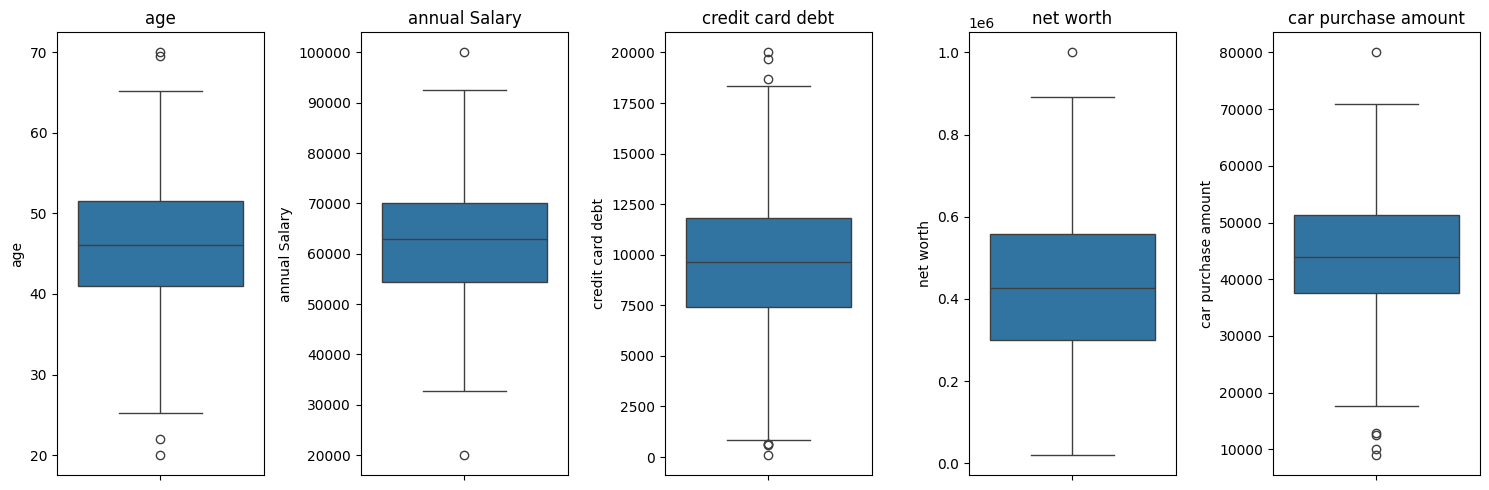

In [16]:
plt.figure(figsize=(15,5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1,5,i)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [17]:
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data[col] = np.where(data[col] > Q3 + 1.5*IQR, Q3 + 1.5*IQR,
                        np.where(data[col] < Q1 - 1.5*IQR, Q1 - 1.5*IQR, data[col]))

In [18]:
data = data.drop(['customer name', 'customer e-mail'], axis=1)

In [19]:
le = LabelEncoder()
data['gender'] = le.fit_transform(data['gender'])

In [20]:
data = pd.get_dummies(data, columns=['country'], prefix='country')

In [21]:
scaler = StandardScaler()
scaled_cols = ['age', 'annual Salary', 'credit card debt', 'net worth']
data[scaled_cols] = scaler.fit_transform(data[scaled_cols])

### **# Exploratory Data Analysis**

<Figure size 1200x800 with 0 Axes>

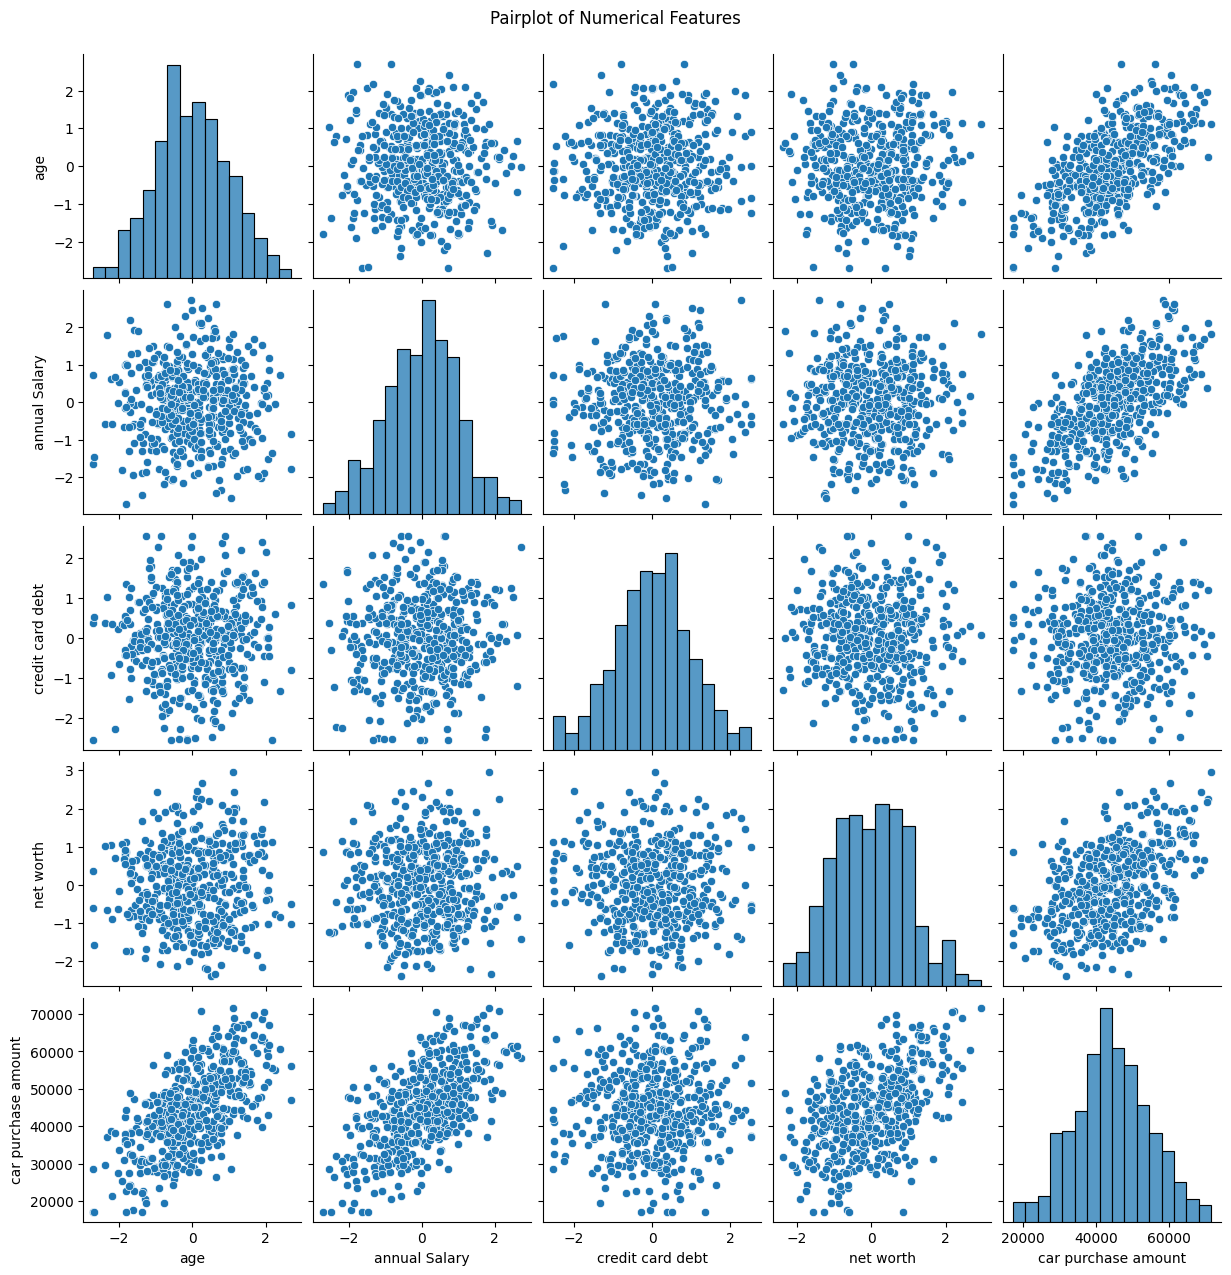

In [22]:
plt.figure(figsize=(12,8))
sns.pairplot(data[numerical_cols])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

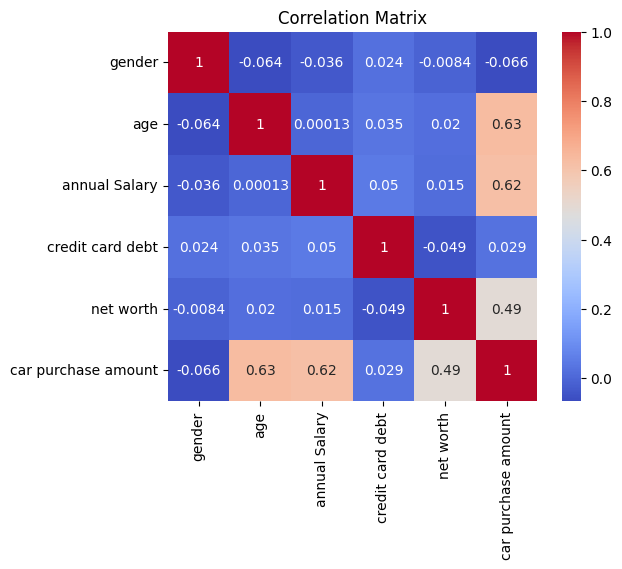

In [28]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

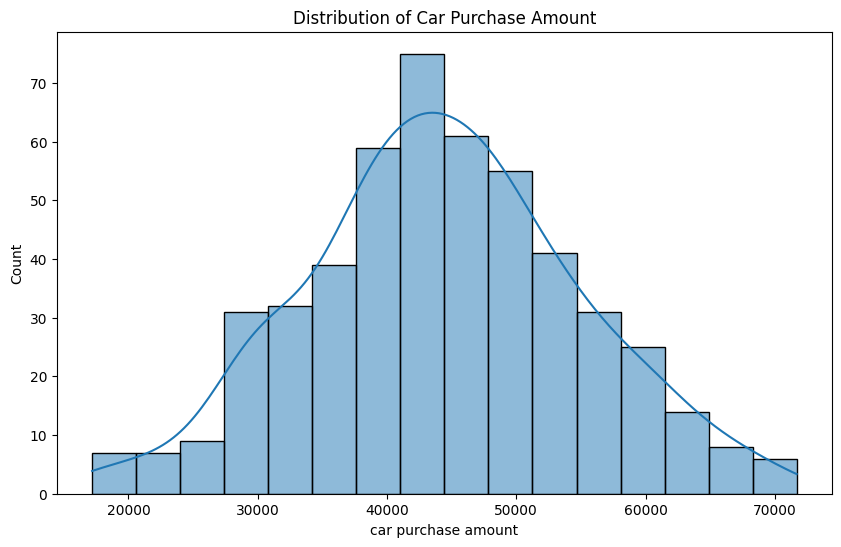

In [29]:
plt.figure(figsize=(10,6))
sns.histplot(data['car purchase amount'], kde=True)
plt.title('Distribution of Car Purchase Amount')
plt.show()

### **# Feature Engineering**

In [30]:
data['debt_to_income_ratio'] = data['credit card debt'] / data['annual Salary']
data['savings'] = data['net worth'] - data['credit card debt']

### **# Model Building**

In [31]:
X = data.drop('car purchase amount', axis=1)
y = data['car purchase amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': GridSearchCV(
        RandomForestRegressor(),
        {'n_estimators': [50, 100], 'max_depth': [None, 5, 10]}),
    'XGBoost': GridSearchCV(
        XGBRegressor(),
        {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.01]})
}

results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Get best model if using GridSearchCV
    if isinstance(model, GridSearchCV):
        best_model = model.best_estimator_
        print(f"\nBest parameters for {name}: {model.best_params_}")
    else:
        best_model = model

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Store results
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }



Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 50}

Best parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 100}


### **# Model Evaluation**

In [35]:
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
                           MAE         RMSE        R2
Linear Regression   274.830276   426.382779  0.998316
Random Forest      1796.371277  2480.251255  0.943026
XGBoost            1621.778708  2212.671901  0.954656


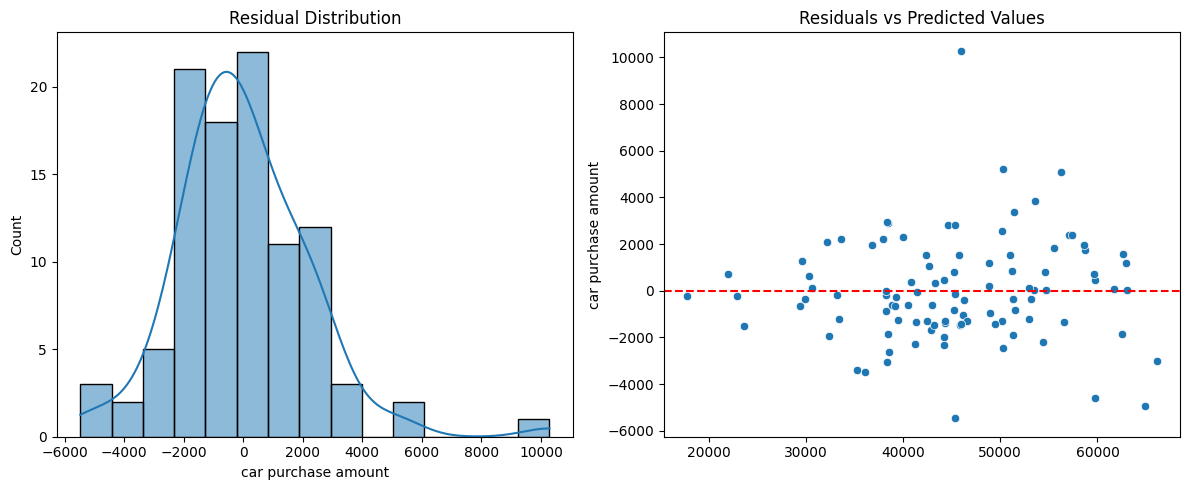

In [36]:
best_model = models['XGBoost'].best_estimator_ if 'XGBoost' in models else None
if best_model:
    y_pred = best_model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(residuals, kde=True)
    plt.title('Residual Distribution')

    plt.subplot(1,2,2)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs Predicted Values')
    plt.tight_layout()
    plt.show()

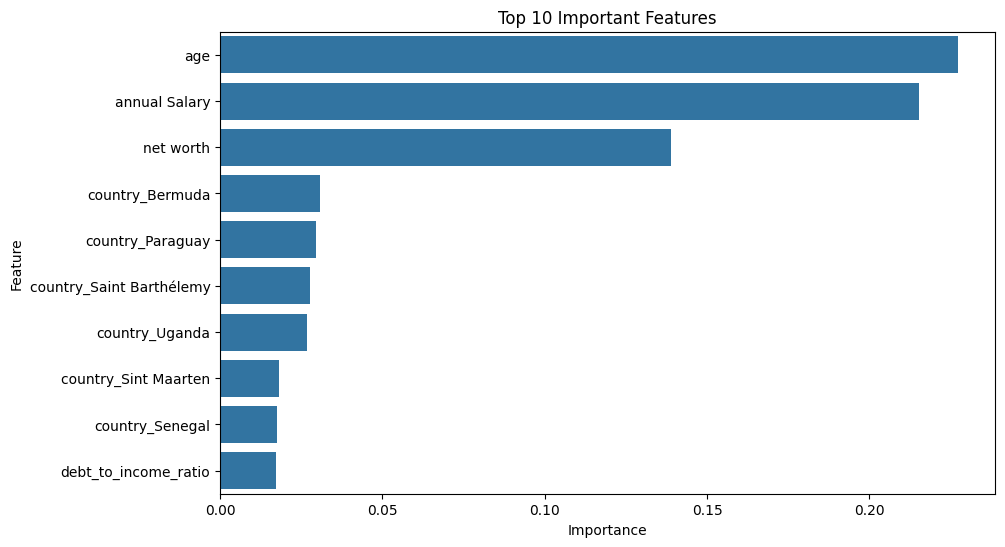

In [37]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    plt.title('Top 10 Important Features')
    plt.show()